Loaded Step 5 dataset:
(1500, 19)
   core_radius_cm  blanket_thickness_cm   height_cm  initial_U233_frac  \
0       72.044062             58.926568  261.886091           0.001300   
1      134.285192             77.599991  145.809614           0.006420   
2      137.872188             83.166553  161.502825           0.011585   

   core_aspect  blanket_to_core_radius_ratio  keff_est   eta_est  \
0     1.817541                      1.817924  0.069357  0.069442   
1     0.542910                      1.577875  0.390571  0.391003   
2     0.585698                      1.603215  0.607253  0.607698   

   flux_shape_metric  breeding_proxy_atoms  breeding_proxy_norm  \
0           0.391945          2.170766e+21         3.205770e-09   
1           0.501716          4.637460e+21         4.710024e-09   
2           0.488234          8.673855e+21         7.322612e-09   

   total_power_W  avg_core_power_density_W_cm3  violates_power_envelope  \
0   2.390141e+06                      0.559712      

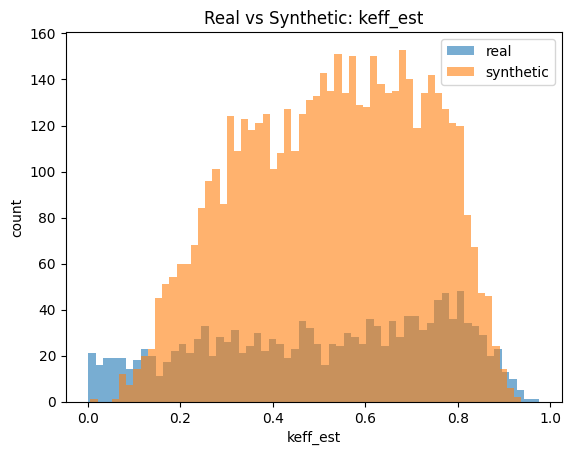

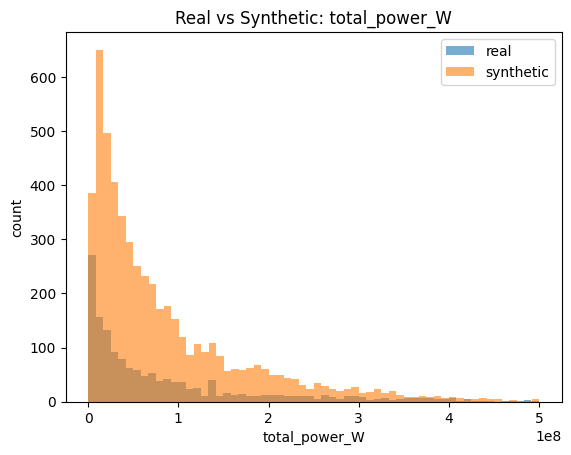

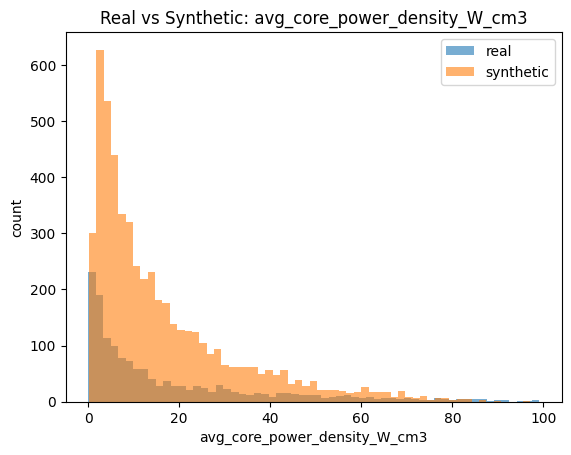

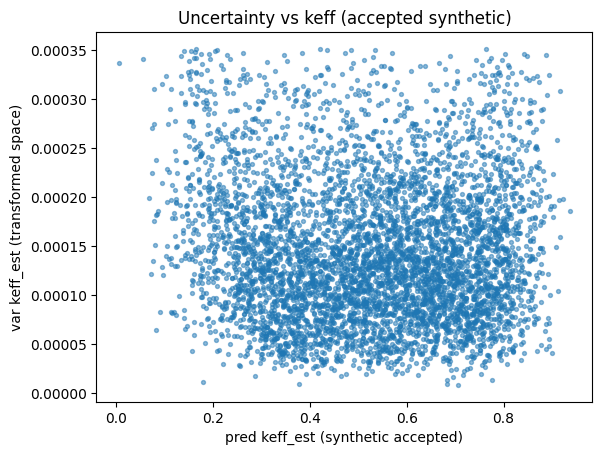


DONE: Chapter 6 augmentation pipeline complete.


In [6]:
# Chapter 6 — Deep Ensemble Augmentation
# The workflow is as follows:
# 1) Ingest the Step 5 dataset/s (Parquet/CSV/NPZ)
# 2) Train Deep Ensemble regressor (uncertainty via ensemble variance)
# 3) Generate synthetic candidates within the design domain
# 4) Filter synthetic points (Hard constraints + Uncertainty thresholds)
# 5) Report dataset quality (Holdout metrics + distribution shift checks)

!pip -q install numpy pandas pyarrow scikit-learn matplotlib scipy

import os
import json
import math
import random
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List, Optional

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from scipy.stats import wasserstein_distance, ks_2samp

import matplotlib.pyplot as plt

# Block 1 - Initialization
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Block 2 - Defining Data Paths
DATA_PARQUET = "/content/surrogate_dataset.parquet"
DATA_CSV     = "/content/surrogate_dataset.csv"
DATA_NPZ     = "/content/surrogate_dataset.npz"
SCHEMA_JSON  = "/content/dataset_schema.json"
NUC_JSON     = "/content/nuclear_data.json"
MAT_JSON     = "/content/material_library.json"

OUT_DIR = "Chapter6_Output"
os.makedirs(OUT_DIR, exist_ok=True)

# Block 3 - Utilities
def load_step5_dataset() -> pd.DataFrame:
    """Load dataset from Parquet (preferred), else CSV, else NPZ."""
    if os.path.exists(DATA_PARQUET):
        df = pd.read_parquet(DATA_PARQUET)
        return df
    if os.path.exists(DATA_CSV):
        df = pd.read_csv(DATA_CSV)
        return df
    if os.path.exists(DATA_NPZ):
        z = np.load(DATA_NPZ, allow_pickle=True)
        cols = list(z.files)
        df = pd.DataFrame({c: z[c] for c in cols})
        return df
    raise FileNotFoundError("No Step 5 dataset found (parquet/csv/npz).")


def load_json(path: str) -> Dict[str, Any]:
    if not os.path.exists(path):
        return {}
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def summarize_df(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df[cols].describe().T
    # Keep common stats for quick glance
    keep = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
    out = out[[c for c in keep if c in out.columns]]
    return out


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(math.sqrt(mean_squared_error(y_true, y_pred)))

# Block 4 - Ingestion of the data as provided in Block 2
df = load_step5_dataset()
schema = load_json(SCHEMA_JSON)
matlib = load_json(MAT_JSON)
nuc    = load_json(NUC_JSON)

print("Loaded Step 5 dataset:")
print(df.shape)
print(df.head(3))

# Required columns (Inputs)
X_COLS = ["core_radius_cm", "blanket_thickness_cm", "height_cm", "initial_U233_frac"]

# Targets to model (Continuous outputs)
Y_COLS = [
    "keff_est",
    "flux_shape_metric",
    "breeding_proxy_norm",
    "total_power_W",
    "avg_core_power_density_W_cm3",
]

LOG_TARGETS = {
    "breeding_proxy_norm",
    "total_power_W",
    "avg_core_power_density_W_cm3",
}

EPS = 1e-30  # This protects the log for extremely small values

def transform_Y(Y: np.ndarray, y_cols: List[str]) -> np.ndarray:
    Yt = Y.astype(float).copy()
    for j, name in enumerate(y_cols):
        if name in LOG_TARGETS:
            Yt[:, j] = np.log10(np.maximum(Yt[:, j], EPS))
    return Yt

def inverse_transform_mu_var(mu_t: np.ndarray, var_t: np.ndarray, y_cols: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert predictive mean/variance from transformed space back to physical space.
    For log10 targets: y = 10^z
      mu_y = 10^(mu_z)
      var_y ≈ (ln(10) * 10^(mu_z))^2 * var_z   (delta method)
    """
    mu = mu_t.astype(float).copy()
    var = var_t.astype(float).copy()
    ln10 = math.log(10.0)

    for j, name in enumerate(y_cols):
        if name in LOG_TARGETS:
            mu_z = mu[:, j]
            var_z = np.maximum(var[:, j], 0.0)

            mu_y = np.power(10.0, mu_z)
            # delta-method variance propagation
            var_y = (ln10 * mu_y) ** 2 * var_z

            mu[:, j] = mu_y
            var[:, j] = var_y
    return mu, var

missing = [c for c in X_COLS + Y_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Keep only numeric rows
df = df.copy()
for c in X_COLS + Y_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=X_COLS + Y_COLS).reset_index(drop=True)

print("\nDataset summary (key columns):")
print(summarize_df(df, X_COLS + Y_COLS))

# Block 5 - Constraints for filtering synthetic data
# N.B: Hard envelopes (These should match the Step 5 data/ schema)
KEFF_TARGET_MAX = float(schema.get("meta", {}).get("subcritical_gate", {}).get("keff_target_max", 0.98))
POWER_ENV_MAX_W = float(schema.get("meta", {}).get("envelopes", {}).get("power_W_max", 5e8))
PD_ENV_MAX      = float(schema.get("meta", {}).get("envelopes", {}).get("power_density_W_cm3_max", 100.0))

# Domain bounds inferred from real dataset (more robust than hardcoding)
DOMAIN = {
    "core_radius_cm": (float(df["core_radius_cm"].min()), float(df["core_radius_cm"].max())),
    "blanket_thickness_cm": (float(df["blanket_thickness_cm"].min()), float(df["blanket_thickness_cm"].max())),
    "height_cm": (float(df["height_cm"].min()), float(df["height_cm"].max())),
    "initial_U233_frac": (float(df["initial_U233_frac"].min()), float(df["initial_U233_frac"].max())),
}

print("\nDerived design-domain bounds:")
for k, (a, b) in DOMAIN.items():
    print(f"  {k}: [{a:.6g}, {b:.6g}]")

# Block 6 - Training / Validation / Test split
X = df[X_COLS].to_numpy(dtype=float)
Y = df[Y_COLS].to_numpy(dtype=float)

# Transform targets for training stability
Y_t = transform_Y(Y, Y_COLS)

# Keep indices for leakage checks and proper reporting
idx = np.arange(len(df))

idx_train, idx_tmp = train_test_split(idx, test_size=0.30, random_state=SEED, shuffle=True)
idx_val, idx_test = train_test_split(idx_tmp, test_size=0.50, random_state=SEED, shuffle=True)

X_train, Y_train_t = X[idx_train], Y_t[idx_train]
X_val,   Y_val_t   = X[idx_val],   Y_t[idx_val]
X_test,  Y_test_t  = X[idx_test],  Y_t[idx_test]

print("\n The Splits:")
print("  train:", X_train.shape, Y_train_t.shape)
print("  val  :", X_val.shape, Y_val_t.shape)
print("  test :", X_test.shape, Y_test_t.shape)

# Block 7 - Deep Ensemble model
# We use an ensemble of MLPRegressors with different seeds.
# Uncertainty proxy: Per target predictive variance across ensemble members.
@dataclass
class EnsembleConfig:
    n_members: int = 7
    hidden_layer_sizes: Tuple[int, ...] = (128, 128, 64)
    alpha: float = 1e-5
    max_iter: int = 2000
    early_stopping: bool = True
    validation_fraction: float = 0.15


def make_member(seed: int, cfg: EnsembleConfig) -> Pipeline:
    model = MLPRegressor(
        hidden_layer_sizes=cfg.hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=cfg.alpha,
        batch_size="auto",
        learning_rate="adaptive",
        max_iter=cfg.max_iter,
        random_state=seed,
        early_stopping=cfg.early_stopping,
        validation_fraction=cfg.validation_fraction,
        n_iter_no_change=30,
        verbose=False,
    )
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", model)
    ])
    return pipe


def fit_ensemble(Xtr, Ytr, Xva, Yva, cfg: EnsembleConfig) -> List[Pipeline]:
    members = []
    for i in range(cfg.n_members):
        seed = SEED + 1000 + i
        m = make_member(seed, cfg)
        m.fit(Xtr, Ytr)
        members.append(m)
    return members


def ensemble_predict(members: List[Pipeline], X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return (mean_pred, var_pred) where var is across members per output dim."""
    preds = []
    for m in members:
        preds.append(m.predict(X))
    P = np.stack(preds, axis=0)  # [M, N, D]
    mu = np.mean(P, axis=0)
    var = np.var(P, axis=0, ddof=1) if P.shape[0] > 1 else np.zeros_like(mu)
    return mu, var


ens_cfg = EnsembleConfig(n_members=9)
ensemble = fit_ensemble(X_train, Y_train_t, X_val, Y_val_t, ens_cfg)

# Block 7.a - Sanity checks: Data leakage
# 1) Overlap check between train and test inputs (should be 0)
train_set = set(map(tuple, np.round(X_train, 12)))
test_set  = set(map(tuple, np.round(X_test, 12)))
print("\nLeakage check: overlap(train,test) rows =", len(train_set.intersection(test_set)))

# 2) Shuffle-target test (R2 should collapse)
Y_shuf = Y_train_t.copy()
np.random.default_rng(SEED + 123).shuffle(Y_shuf)  # shuffles rows

m_sanity = make_member(SEED + 7777, EnsembleConfig(n_members=1))  # single member ok
m_sanity.fit(X_train, Y_shuf)
pred_shuf = m_sanity.predict(X_test)

# Compare in transformed space (since model was trained in transformed space)
r2_shuf = r2_score(Y_test_t[:, 0], pred_shuf[:, 0])
print("Leakage check: shuffled-target R2 for first target =", float(r2_shuf))

# Block 8 - Evaluate on test
# Predict in transformed space
mu_test_t, var_test_t = ensemble_predict(ensemble, X_test)

# Convert predictions back to physical space
mu_test, var_test = inverse_transform_mu_var(mu_test_t, var_test_t, Y_COLS)

# Build matching physical-space ground truth from original Y (not transformed)
# We reconstruct it by re-splitting indices: easiest is to store indices during split,
# but since you already split arrays, do this:
# Convert the transformed test labels back to physical for fair comparison.
Y_test = inverse_transform_mu_var(Y_test_t, np.zeros_like(Y_test_t), Y_COLS)[0]

metrics = {}
for j, name in enumerate(Y_COLS):
    y_true = Y_test[:, j]
    y_pred = mu_test[:, j]

    metrics[name] = {
        "R2": float(r2_score(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "mean_pred_var": float(np.mean(var_test[:, j])),
        "mean_pred_var_tspace": float(np.mean(var_test_t[:, j])),
    }

    # Also report metrics in log-space for log targets (more diagnostic)
    if name in LOG_TARGETS:
        yt = Y_test_t[:, j]
        yp = mu_test_t[:, j]
        metrics[name]["R2_log10"] = float(r2_score(yt, yp))
        metrics[name]["RMSE_log10"] = rmse(yt, yp)
        metrics[name]["MAE_log10"] = float(mean_absolute_error(yt, yp))

print("\nTest metrics (Ensemble mean predictions):")
for k, v in metrics.items():
    print(f"  {k:26s}  R2={v['R2']:.4f}  RMSE={v['RMSE']:.4g}  MAE={v['MAE']:.4g}  meanVar={v['mean_pred_var']:.4g}")

with open(os.path.join(OUT_DIR, "ensemble_test_metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

# Block 9 - Synthetic candidate generation
def lhs_sample(n: int, bounds: Dict[str, Tuple[float, float]]) -> np.ndarray:
    """Simple Latin Hypercube sampling in [0,1] then scale to bounds."""
    d = len(bounds)
    rng = np.random.default_rng(SEED + 999)
    cut = np.linspace(0, 1, n + 1)
    u = rng.random((n, d))
    a = cut[:n]
    b = cut[1:n+1]
    rdpoints = u * (b - a)[:, None] + a[:, None]
    H = np.zeros_like(rdpoints)
    for j in range(d):
        order = rng.permutation(n)
        H[:, j] = rdpoints[order, j]
    # scale
    Xs = np.zeros((n, d), dtype=float)
    for j, key in enumerate(bounds.keys()):
        lo, hi = bounds[key]
        Xs[:, j] = lo + H[:, j] * (hi - lo)
    return Xs


N_SYN_CANDIDATES = 25000
X_syn = lhs_sample(N_SYN_CANDIDATES, {k: DOMAIN[k] for k in X_COLS})

# Predict the Mean and Variance
mu_syn_t, var_syn_t = ensemble_predict(ensemble, X_syn)
mu_syn, var_syn = inverse_transform_mu_var(mu_syn_t, var_syn_t, Y_COLS)

# Block 10 - Filtering synthetic points
# The Hard constraints we define in are as follows:
#  - keff < KEFF_TARGET_MAX
#  - total_power <= POWER_ENV_MAX_W
#  - avg_core_power_density <= PD_ENV_MAX
# Uncertainty constraints:
#  - Per target variance below robust thresholds (quantiles on real data predictive variance)

# 1) Build variance thresholds from REAL data predictions
mu_real_t, var_real_t = ensemble_predict(ensemble, X_train)

VAR_Q = 0.90
var_thresh_t = np.quantile(var_real_t, VAR_Q, axis=0)  # Thresholds in transformed space

# 2) Apply hard physical constraints on predicted means
idx_keff = Y_COLS.index("keff_est")
idx_pow  = Y_COLS.index("total_power_W")
idx_pd   = Y_COLS.index("avg_core_power_density_W_cm3")

hard_ok = (
    (mu_syn[:, idx_keff] > 0.0) & (mu_syn[:, idx_keff] < KEFF_TARGET_MAX) &
    (mu_syn[:, idx_pow]  > 0.0) & (mu_syn[:, idx_pow]  <= POWER_ENV_MAX_W) &
    (mu_syn[:, idx_pd]   > 0.0) & (mu_syn[:, idx_pd]   <= PD_ENV_MAX)
)

# 3) Apply uncertainty gate: all targets below threshold
unc_ok = np.all(var_syn_t <= var_thresh_t[None, :], axis=1)

# 4) Combined accept
accept = hard_ok & unc_ok

X_acc = X_syn[accept]
mu_acc = mu_syn[accept]
var_acc = var_syn[accept]

print("\nSynthetic generation:")
print(f"  candidates: {len(X_syn)}")
print(f"  accepted  : {len(X_acc)}")
print(f"  accept rate: {len(X_acc)/max(1,len(X_syn)):.4f}")

# Save synthetic candidates + accepted subsets
syn_cols = X_COLS + [f"pred_{c}" for c in Y_COLS] + [f"var_{c}" for c in Y_COLS]

def pack_df(Xm, mu, var) -> pd.DataFrame:
    d = {}
    for j, c in enumerate(X_COLS):
        d[c] = Xm[:, j]
    for j, c in enumerate(Y_COLS):
        d[f"pred_{c}"] = mu[:, j]
        d[f"var_{c}"] = var[:, j]
    return pd.DataFrame(d)

syn_df = pack_df(X_syn, mu_syn, var_syn)
acc_df = pack_df(X_acc, mu_acc, var_acc)

syn_path = os.path.join(OUT_DIR, "synthetic_candidates.parquet")
acc_path = os.path.join(OUT_DIR, "synthetic_accepted.parquet")

syn_df.to_parquet(syn_path, index=False)
acc_df.to_parquet(acc_path, index=False)

# Block 11 - Build augmented dataset
# We append accepted synthetic points as additional training data.
# For targets, we use ensemble mean predictions (mu_acc).

# Construct augmented frame in the SAME column naming scheme as real dataset
aug_syn = pd.DataFrame(X_acc, columns=X_COLS)
for j, c in enumerate(Y_COLS):
    aug_syn[c] = mu_acc[:, j]
aug_syn["is_synthetic"] = True

real_df = df[X_COLS + Y_COLS].copy()
real_df["is_synthetic"] = False

aug_df = pd.concat([real_df, aug_syn], ignore_index=True)

# Checking Synthetically generated data for  near duplicates (inputs)
if len(X_acc) > 0:
    nn = NearestNeighbors(n_neighbors=1).fit(X)  # real inputs
    d, _ = nn.kneighbors(X_acc)
    report_nn = {
        "median_nn_dist_to_real": float(np.median(d)),
        "p01_nn_dist_to_real": float(np.quantile(d, 0.01)),
        "frac_extremely_close_1e-6": float(np.mean(d < 1e-6)),
        "frac_extremely_close_1e-4": float(np.mean(d < 1e-4)),
    }
else:
    report_nn = {"note": "no synthetic accepted"}


aug_path = os.path.join(OUT_DIR, "augmented_dataset.parquet")
aug_df.to_parquet(aug_path, index=False)

print("\nAugmented dataset saved:")
print(" ", aug_path)
print("  rows:", len(aug_df), "(real:", len(real_df), ", synthetic:", len(aug_syn), ")")

# Block 12 - Reporting: How good is the augmented dataset?
# We report the following:
# 1) Model performance on test set BEFORE augmentation
# 2) Distribution shift: compare real vs synthetic distributions for key outputs
# 3) Constraint compliance rates

report = {
    "ensemble_members": ens_cfg.n_members,
    "var_quantile_gate": VAR_Q,
    "var_thresholds_tspace": {Y_COLS[j]: float(var_thresh_t[j]) for j in range(len(Y_COLS))},
    "hard_limits": {
        "keff_target_max": KEFF_TARGET_MAX,
        "power_W_max": POWER_ENV_MAX_W,
        "power_density_W_cm3_max": PD_ENV_MAX,
    },
    "counts": {
        "real_rows": int(len(real_df)),
        "synthetic_candidates": int(len(syn_df)),
        "synthetic_accepted": int(len(aug_syn)),
        "augmented_rows": int(len(aug_df)),
    },
    "test_metrics": metrics,
}

# Attach NN duplicate/proximity report (computed earlier)
report["synthetic_nn_proximity"] = report_nn

# ----------------------------
# Design-space coverage (inputs): real vs synthetic bounds
# ----------------------------
coverage = {}
if len(X_acc) > 0:
    for j, k in enumerate(X_COLS):
        coverage[k] = {
            "real_min": float(np.min(X[:, j])),
            "real_max": float(np.max(X[:, j])),
            "syn_min": float(np.min(X_acc[:, j])),
            "syn_max": float(np.max(X_acc[:, j])),
        }
else:
    for j, k in enumerate(X_COLS):
        coverage[k] = {
            "real_min": float(np.min(X[:, j])),
            "real_max": float(np.max(X[:, j])),
            "syn_min": None,
            "syn_max": None,
        }
report["design_space_coverage_inputs"] = coverage

# Distribution distances (targets): Wasserstein + KS
distances = {}
for c in Y_COLS:
    r = real_df[c].to_numpy(dtype=float)
    s = aug_syn[c].to_numpy(dtype=float) if len(aug_syn) else np.array([])
    if len(s) == 0:
        distances[c] = {"note": "no synthetic accepted"}
        continue
    distances[c] = {
        "wasserstein": float(wasserstein_distance(r, s)),
        "ks_stat": float(ks_2samp(r, s).statistic),
    }
report["distribution_distance"] = distances

# Constraint compliance check on accepted synthetic means
syn_keff_ok = float(np.mean((mu_acc[:, idx_keff] > 0.0) & (mu_acc[:, idx_keff] < KEFF_TARGET_MAX))) if len(mu_acc) else 0.0
syn_pow_ok  = float(np.mean((mu_acc[:, idx_pow]  > 0.0) & (mu_acc[:, idx_pow]  <= POWER_ENV_MAX_W))) if len(mu_acc) else 0.0
syn_pd_ok   = float(np.mean((mu_acc[:, idx_pd]   > 0.0) & (mu_acc[:, idx_pd]   <= PD_ENV_MAX))) if len(mu_acc) else 0.0

report["synthetic_compliance"] = {
    "keff_ok_rate": syn_keff_ok,
    "power_ok_rate": syn_pow_ok,
    "power_density_ok_rate": syn_pd_ok,
}

# Simple distribution shift stats (mean/std and KS-like heuristic via quantile gaps)
shift = {}
for c in Y_COLS:
    r = real_df[c].to_numpy(dtype=float)
    s = aug_syn[c].to_numpy(dtype=float) if len(aug_syn) else np.array([])
    if len(s) == 0:
        shift[c] = {"note": "no synthetic accepted"}
        continue
    qs = [0.05, 0.25, 0.50, 0.75, 0.95]
    rq = np.quantile(r, qs)
    sq = np.quantile(s, qs)
    shift[c] = {
        "real_mean": float(np.mean(r)),
        "syn_mean": float(np.mean(s)),
        "real_std": float(np.std(r)),
        "syn_std": float(np.std(s)),
        "quantile_abs_gaps": {str(qs[i]): float(abs(rq[i] - sq[i])) for i in range(len(qs))},
    }

report["distribution_shift"] = shift

report_path = os.path.join(OUT_DIR, "augmentation_report.json")
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\nReport saved:")
print(" ", report_path)

# Block 13 - Quick Plots
def plot_real_vs_syn(col: str, bins: int = 60):
    r = real_df[col].to_numpy(dtype=float)
    s = aug_syn[col].to_numpy(dtype=float) if len(aug_syn) else np.array([])
    plt.figure()
    plt.hist(r, bins=bins, alpha=0.6, label="real")
    if len(s):
        plt.hist(s, bins=bins, alpha=0.6, label="synthetic")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()
    plt.title(f"Real vs Synthetic: {col}")
    plt.show()

# Plot a couple of key columns
plot_real_vs_syn("keff_est")
plot_real_vs_syn("total_power_W")
plot_real_vs_syn("avg_core_power_density_W_cm3")

# Optional diagnostic: uncertainty vs keff (accepted synthetic)
if len(var_acc) > 0:
    plt.figure()
    plt.scatter(mu_acc[:, idx_keff], var_syn_t[accept][:, idx_keff], s=8, alpha=0.5)
    plt.xlabel("pred keff_est (synthetic accepted)")
    plt.ylabel("var keff_est (transformed space)")
    plt.title("Uncertainty vs keff (accepted synthetic)")
    plt.show()

print("\nDONE: Chapter 6 augmentation pipeline complete.")
